In [32]:
import pandas as pd
import numpy as np

In [33]:
# Create a time index for a year
# Using the provided date range
timestamps = pd.to_datetime(pd.date_range(start='2022-01-01', end='2025-06-14', freq='h'))

In [34]:
# --- HVAC Energy Data Generation ---
# 1. Baseline consumption
baseline_hvac = 150  # kWh

# 2. Seasonal component (sine wave)
# Peaks in summer (day 80 approx March 20th)
# Convert to NumPy array
seasonal_hvac = (50 * np.sin(2 * np.pi * (timestamps.dayofyear - 80) / 365)).values

# 3. Daily component (higher during store hours)
# Peaks in the afternoon (around hour 8, i.e., 8 AM, then again at 8 PM roughly)
# Convert the result to a NumPy array to make it mutable
daily_hvac = (75 * np.sin(2 * np.pi * (timestamps.hour - 8) / 24)).values
daily_hvac[timestamps.hour < 7] = 0  # Store closed before 7 AM
daily_hvac[timestamps.hour > 22] = 0 # Store closed after 10 PM

# 4. Random noise
noise_hvac = np.random.normal(0, 10, len(timestamps))

# Combine components for HVAC
hvac_consumption = baseline_hvac + seasonal_hvac + daily_hvac + noise_hvac
hvac_consumption[hvac_consumption < 0] = 0 # Consumption can't be negative

hvac_df = pd.DataFrame({'timestamp': timestamps, 'HVAC_Energy(t)': hvac_consumption})

In [35]:
# --- Refrigeration Energy Data Generation ---
# 1. Strong baseline
baseline_fridge = 200  # kWh

# 2. Minor daily fluctuation
daily_fridge = 10 * np.sin(2 * np.pi * (timestamps.hour - 10) / 24)

# 3. Simulate random defrost cycles (e.g., a few times a day)
defrost_spikes = np.random.choice([0, 50], size=len(timestamps), p=[0.98, 0.02])

# 4. Random noise
noise_fridge = np.random.normal(0, 5, len(timestamps))

# Combine components for Refrigeration
refrigeration_consumption = baseline_fridge + daily_fridge + defrost_spikes + noise_fridge

fridge_df = pd.DataFrame({'timestamp': timestamps, 'Refrigeration_Energy(t)': refrigeration_consumption})


In [36]:
# --- Lighting Energy Data Generation ---
# 1. Baseline (on/off)
lighting_consumption = np.zeros(len(timestamps))
# Lights on from 7 AM to 10 PM
lighting_consumption[(timestamps.hour >= 7) & (timestamps.hour <= 22)] = 100

# 2. Daylight harvesting effect (subtle dip midday)
# Effect peaks mid-day within operating hours
daylight_effect = 20 * np.sin(np.pi * (timestamps.hour - 7) / 15)

# Convert daylight_effect to a NumPy array to make it mutable
daylight_effect = daylight_effect.values

daylight_effect[timestamps.hour < 7] = 0
daylight_effect[timestamps.hour > 22] = 0
lighting_consumption -= daylight_effect

# 3. Random noise
noise_lighting = np.random.normal(0, 2, len(timestamps))
lighting_consumption += noise_lighting
lighting_consumption[lighting_consumption < 0] = 0

lighting_df = pd.DataFrame({'timestamp': timestamps, 'Lighting_Energy(t)': lighting_consumption})

In [37]:
# --- Solar Generation Data Generation (Increased for more surplus) ---
daily_solar = 300 * np.sin(np.pi * (timestamps.hour - 6) / 12).values
daily_solar[timestamps.hour < 6] = 0
daily_solar[timestamps.hour > 18] = 0
seasonal_solar = 100 * np.sin(2 * np.pi * (timestamps.dayofyear - 172) / 365).values
seasonal_solar[timestamps.hour < 6] = 0
seasonal_solar[timestamps.hour > 18] = 0
cloud_cover = np.random.uniform(0.3, 1, len(timestamps))
# This is the total solar power generated initially
total_solar_generation = (daily_solar + seasonal_solar) * cloud_cover
total_solar_generation[total_solar_generation < 0] = 0

In [38]:
# --- Electricity Price Data Generation ---
# 1. Base price
base_price = 0.10  # $/kWh

# 2. TOU (Time Of Use) pricing
tou_price = np.zeros(len(timestamps))
tou_price[(timestamps.hour >= 14) & (timestamps.hour <= 20)] = 0.08 # Peak price 2 PM to 8 PM
tou_price[timestamps.hour <= 6] = -0.03 # Off-peak credit before 6 AM

# 3. Seasonal adjustment
# Higher in summer (day 172 approx June 21st)
# Convert to NumPy array before use in calculation
seasonal_price_adj = (0.02 * np.sin(2 * np.pi * (timestamps.dayofyear - 172) / 365)).values

# 4. Random noise
noise_price = np.random.normal(0, 0.005, len(timestamps))

# Combine components for Electricity Price
# Ensure all components are NumPy arrays for consistent type
electricity_price = base_price + tou_price + seasonal_price_adj + noise_price
# Ensure price doesn't go negative or too low unrealistically
electricity_price[electricity_price < 0.01] = 0.01

price_df = pd.DataFrame({'timestamp': timestamps, 'Electricity_Price(t)': electricity_price})

In [39]:
# --- IT System Power Consumption Generation ---
# IT systems often have a relatively stable baseline with some daily fluctuation
baseline_it = 80 # kWh
# Convert the result to a NumPy array to make it mutable
daily_it = (30 * np.sin(2 * np.pi * (timestamps.hour - 9) / 24)).values # Higher during typical business hours
noise_it = np.random.normal(0, 5, len(timestamps))
# Ensure all components are NumPy arrays for consistent type
it_consumption = baseline_it + daily_it + noise_it
it_consumption[it_consumption < 0] = 0
it_df = pd.DataFrame({'timestamp': timestamps, 'IT_System(t)': it_consumption})

In [40]:
# --- Other System Power Consumption Generation ---
# More varied consumption pattern for general "other" loads
baseline_other = 50 # kWh
daily_other = 20 * np.sin(2 * np.pi * (timestamps.hour - 12) / 24).values # Some daily pattern
noise_other = np.random.normal(0, 7, len(timestamps))
other_consumption = baseline_other + daily_other + noise_other
other_consumption[other_consumption < 0] = 0
other_df = pd.DataFrame({'timestamp': timestamps, 'Other_System(t)': other_consumption})

In [41]:
# --- Merging all DataFrames ---
merged_df = hvac_df
merged_df = pd.merge(merged_df, fridge_df, on='timestamp', how='left')
merged_df = pd.merge(merged_df, lighting_df, on='timestamp', how='left')
merged_df = pd.merge(merged_df, it_df, on='timestamp', how='left') # Merge IT system data
merged_df = pd.merge(merged_df, other_df, on='timestamp', how='left') # Merge Other system data
merged_df = pd.merge(merged_df, price_df, on='timestamp', how='left')

# --- Add Solar Columns with Split ---
# Solar available for use (80% of total generated)
merged_df['Solar_Available_for_Use(t)'] = 0.70 * total_solar_generation
# Initial placeholder for solar used to charge battery (will be calculated in loop)
merged_df['Solar_Used_to_Charge_Battery(t)'] = 0.0
# We will keep 'total_solar_generation' as a Series in this scope but not add it as a column
# to avoid confusion with the user's requested split columns.

# --- Calculate Base Consumption Loads (before battery interaction) ---
merged_df['Base_Consumption_Loads(t)'] = (
    merged_df['HVAC_Energy(t)'] +
    merged_df['Refrigeration_Energy(t)'] +
    merged_df['Lighting_Energy(t)'] +
    merged_df['IT_System(t)'] +
    merged_df['Other_System(t)']
)

# Initialize Total_Energy(t) with base consumption loads; it will be updated with battery charging
merged_df['Total_Energy(t)'] = merged_df['Base_Consumption_Loads(t)'].copy()

In [42]:
# --- Battery Bank Data Generation (Two Batteries) ---
num_battery_banks = 2 # Changed to two batteries as requested
battery_parameters = {
    'capacity_kwh': 500,  # Max energy storage capacity
    'max_rate_kwh': 150,  # Max charge/discharge rate per hour (power flow into/out of battery)
    'charge_efficiency': 0.95, # Efficiency when charging (energy stored = input * efficiency)
    'discharge_efficiency': 0.95, # Efficiency when discharging (energy provided = output * efficiency)
    # 'slow_discharge_factor' will now be generated dynamically in a range
}

# Initialize a list to hold the current energy stored for each battery bank
current_energy_stored_banks = [(battery_parameters['capacity_kwh'] / 2) + np.random.uniform(-50, 50) for _ in range(num_battery_banks)]
current_energy_stored_banks = [np.clip(val, 0, battery_parameters['capacity_kwh']) for val in current_energy_stored_banks]

# Initialize columns for battery charge/discharge and stored energy
for i in range(1, num_battery_banks + 1):
    merged_df[f'Battery_{i}_Charge_Discharge(t)'] = 0.0
    merged_df[f'Battery_{i}_Energy_Stored(t)'] = 0.0

for t in range(len(timestamps)):
    current_base_consumption = merged_df['Base_Consumption_Loads(t)'].iloc[t]
    current_solar_available_for_use = merged_df['Solar_Available_for_Use(t)'].iloc[t]

    # Calculate the potential solar dedicated to battery charging for this hour (30% of total generated)
    solar_dedicated_to_battery_potential = 0.30 * total_solar_generation[t] if total_solar_generation[t] > 0 else 0

    remaining_solar_for_charging = solar_dedicated_to_battery_potential
    current_hour_solar_used_for_charging = 0.0 # Accumulator for solar used to charge batteries this hour

    # Initialize hourly net flows and energy changes for each battery
    hourly_battery_flows = [0.0] * num_battery_banks
    hourly_energy_changes = [0.0] * num_battery_banks

    # --- Phase 1: Battery Charging (from dedicated solar portion) ---
    # First, calculate how much each battery can possibly charge
    possible_charge_amounts_per_battery = []
    for i in range(num_battery_banks):
        if current_energy_stored_banks[i] < battery_parameters['capacity_kwh']:
            max_charge_rate_allowed = battery_parameters['max_rate_kwh']
            space_to_fill_kwh = battery_parameters['capacity_kwh'] - current_energy_stored_banks[i]
            max_charge_input_based_on_capacity = space_to_fill_kwh / battery_parameters['charge_efficiency']

            # Max this individual battery can take, limited by its rate and capacity
            possible_charge_amounts_per_battery.append(min(max_charge_rate_allowed, max_charge_input_based_on_capacity))
        else:
            possible_charge_amounts_per_battery.append(0) # Battery is full

    total_possible_charge_from_all_batteries = sum(possible_charge_amounts_per_battery)

    # Determine the total amount of solar to distribute for charging
    solar_to_distribute_for_charging = min(remaining_solar_for_charging, total_possible_charge_from_all_batteries)

    if solar_to_distribute_for_charging > 0:
        # Distribute the solar equally among batteries that can still accept charge
        # Calculate how many batteries can actually take charge
        num_chargeable_batteries = sum(1 for x in possible_charge_amounts_per_battery if x > 0)

        if num_chargeable_batteries > 0:
            equal_share_per_battery = solar_to_distribute_for_charging / num_chargeable_batteries

            for i in range(num_battery_banks):
                if possible_charge_amounts_per_battery[i] > 0: # If this battery can accept charge
                    charge_amount_for_this_battery = min(equal_share_per_battery, possible_charge_amounts_per_battery[i])

                    # Apply noise and ensure it's non-negative
                    actual_charge_flow_i = charge_amount_for_this_battery + np.random.normal(0, 0.5)
                    actual_charge_flow_i = max(0, actual_charge_flow_i)

                    # Ensure we don't charge more than allocated/possible
                    actual_charge_flow_i = min(actual_charge_flow_i, charge_amount_for_this_battery)

                    hourly_battery_flows[i] = actual_charge_flow_i
                    hourly_energy_changes[i] = actual_charge_flow_i * battery_parameters['charge_efficiency']
                    current_hour_solar_used_for_charging += actual_charge_flow_i

    # --- Phase 2: Battery Discharging (ONLY if solar is NOT available for direct use) ---
    # Calculate the net demand after direct solar use
    net_demand_after_direct_solar = current_base_consumption - current_solar_available_for_use

    # Generate a random slow discharge factor for this hour (between 0.1 and 0.3)
    current_slow_discharge_factor = np.random.uniform(0.1, 0.3)

    # If there's a deficit AND solar is NOT available for use (current_solar_available_for_use must be 0)
    if net_demand_after_direct_solar > 0 and current_solar_available_for_use == 0:
        remaining_deficit = net_demand_after_direct_solar
        for i in range(num_battery_banks):
            # Only discharge if there's a deficit and battery has energy
            if remaining_deficit > 0 and current_energy_stored_banks[i] > 0:
                # Max power battery can provide (rate limit, now slowed down by random factor)
                max_discharge_rate_allowed = battery_parameters['max_rate_kwh'] * current_slow_discharge_factor

                # Max useful energy the battery can provide (based on stored energy, considering efficiency)
                available_discharge_power_from_stored = current_energy_stored_banks[i] * battery_parameters['discharge_efficiency']

                # Amount to attempt to discharge from this battery
                discharge_amount = min(remaining_deficit, max_discharge_rate_allowed, available_discharge_power_from_stored)

                # Apply noise and ensure it's non-negative in magnitude
                actual_discharge_flow_magnitude = discharge_amount + np.random.normal(0, 0.5)
                actual_discharge_flow_magnitude = max(0, actual_discharge_flow_magnitude)

                # Ensure we don't discharge more than is needed for the remaining deficit
                actual_discharge_flow_magnitude = min(actual_discharge_flow_magnitude, remaining_deficit)

                # Update hourly net flow (negative for discharge)
                # Ensure we don't overwrite if battery already charged in Phase 1
                if hourly_battery_flows[i] == 0: # Only apply discharge if battery wasn't charging
                    hourly_battery_flows[i] -= actual_discharge_flow_magnitude

                # Calculate actual energy reduction from stored after efficiency loss
                # Ensure we don't overwrite if battery already charged in Phase 1
                if hourly_energy_changes[i] == 0: # Only apply discharge if battery wasn't charging
                    hourly_energy_changes[i] -= actual_discharge_flow_magnitude / battery_parameters['discharge_efficiency']

                # Update remaining deficit
                remaining_deficit -= actual_discharge_flow_magnitude

    # --- Finalize Battery State for the Hour ---
    for i in range(num_battery_banks):
        # Apply the net energy change to the stored energy
        current_energy_stored_banks[i] += hourly_energy_changes[i]
        # Ensure energy stored stays strictly within bounds [0, capacity]
        current_energy_stored_banks[i] = np.clip(current_energy_stored_banks[i], 0, battery_parameters['capacity_kwh'])

        # Store the calculated net power flow and updated stored energy for the current timestamp
        merged_df.loc[t, f'Battery_{i+1}_Charge_Discharge(t)'] = hourly_battery_flows[i]
        merged_df.loc[t, f'Battery_{i+1}_Energy_Stored(t)'] = current_energy_stored_banks[i]

    # Store the total solar used for charging batteries for this hour
    merged_df.loc[t, 'Solar_Used_to_Charge_Battery(t)'] = current_hour_solar_used_for_charging

# --- Final Recalculation of Total_Energy(t) to include battery charging ---
# Total_Energy(t) now represents the sum of all direct consumption loads
# PLUS any power used to charge the batteries (which is now from Solar_Used_to_Charge_Battery(t)).
merged_df['Total_Energy(t)'] = merged_df['Base_Consumption_Loads(t)'].copy() # Reset Total_Energy to base loads
merged_df['Total_Energy(t)'] += merged_df['Solar_Used_to_Charge_Battery(t)']

In [44]:
# Display the first few rows of the final DataFrame
print("--- Final Merged DataFrame Head ---")
print(merged_df.head())

# Display info about the final DataFrame to check for missing values or incorrect types
print("\n--- Final Merged DataFrame Info ---")
print(merged_df.info())

--- Final Merged DataFrame Head ---
            timestamp  HVAC_Energy(t)  Refrigeration_Energy(t)  \
0 2022-01-01 00:00:00      111.226592               196.685501   
1 2022-01-01 01:00:00       89.005608               206.330939   
2 2022-01-01 02:00:00      115.423028               200.257985   
3 2022-01-01 03:00:00       95.907992               182.592128   
4 2022-01-01 04:00:00      100.240215               184.117794   

   Lighting_Energy(t)  IT_System(t)  Other_System(t)  Electricity_Price(t)  \
0            0.000000     69.532528        50.049217              0.065712   
1            2.548394     55.134340        42.159803              0.062687   
2            0.000000     46.503376        44.013516              0.065485   
3            0.405717     42.987014        32.565693              0.061437   
4            0.000000     45.160155        31.403503              0.067825   

   Solar_Available_for_Use(t)  Solar_Used_to_Charge_Battery(t)  \
0                         0.0   

In [45]:
merged_df.head(10)

,timestamp,HVAC_Energy(t),Refrigeration_Energy(t),Lighting_Energy(t),IT_System(t),Other_System(t),Electricity_Price(t),Solar_Available_for_Use(t),Solar_Used_to_Charge_Battery(t),Base_Consumption_Loads(t),Total_Energy(t),Battery_1_Charge_Discharge(t),Battery_1_Energy_Stored(t),Battery_2_Charge_Discharge(t),Battery_2_Energy_Stored(t)
0,2022-01-01 00:00:00,111.226592,196.685501,0.000000,69.532528,50.049217,0.065712,0.000000,0.000000,427.493838,427.493838,-39.959290,171.316403,-39.515056,210.604568
1,2022-01-01 01:00:00,89.005608,206.330939,2.548394,55.134340,42.159803,0.062687,0.000000,0.000000,395.179084,395.179084,-21.790335,148.379208,-21.999100,187.447621
2,2022-01-01 02:00:00,115.423028,200.257985,0.000000,46.503376,44.013516,0.065485,0.000000,0.000000,406.197906,406.197906,-31.722753,114.986836,-31.018854,154.796196
3,2022-01-01 03:00:00,95.907992,182.592128,0.405717,42.987014,32.565693,0.061437,0.000000,0.000000,354.458544,354.458544,-21.640861,92.206983,-21.541469,132.120966
4,2022-01-01 04:00:00,100.240215,184.117794,0.000000,45.160155,31.403503,0.067825,0.000000,0.000000,360.921667,360.921667,-18.217019,73.031173,-18.019729,113.152830
5,2022-01-01 05:00:00,87.003823,190.056251,0.000000,54.622129,28.695630,0.075250,0.000000,0.000000,360.377833,360.377833,-28.883299,42.627700,-28.571637,83.077422
6,2022-01-01 06:00:00,113.664754,191.907137,2.564874,57.610619,34.607946,0.063857,0.000000,0.000000,400.355330,400.355330,-17.651229,24.047459,-18.443802,63.662893
7,2022-01-01 07:00:00,89.019865,194.401267,98.652931,66.326336,27.596122,0.094056,28.964976,10.986769,475.996521,486.983290,5.684143,29.447395,5.302626,68.700388
8,2022-01-01 08:00:00,98.209935,191.534402,96.693024,76.916140,33.124284,0.100244,35.486838,15.208645,496.477785,511.686430,7.604322,36.671502,7.604322,75.924494
9,2022-01-01 09:00:00,111.550261,191.620239,91.355405,74.332706,42.942462,0.084515,65.538027,27.694911,511.801073,539.495984,14.043863,50.013172,13.651048,88.892990


In [46]:
import os

base_output_folder = 'historical_store1_energy_data'
if not os.path.exists(base_output_folder):
    os.makedirs(base_output_folder)
    print(f"\nCreated base folder: '{base_output_folder}'.")

# Save each row as a separate CSV file in the new hierarchical structure
for index, row in merged_df.iterrows():
    # Extract year, month, day, and hour from the timestamp
    year = row['timestamp'].strftime('%Y')
    month = row['timestamp'].strftime('%m')
    day = row['timestamp'].strftime('%d')
    hour = row['timestamp'].strftime('%H')

    # Construct the folder path: historical/year=YYYY/month=MM/day=DD
    daily_folder_path = os.path.join(base_output_folder, f'year={year}', f'month={month}', f'day={day}')

    # Create the directory if it doesn't exist
    if not os.path.exists(daily_folder_path):
        os.makedirs(daily_folder_path)
        # print(f"Created folder: '{daily_folder_path}'") # Optional: print for each folder

    # Define the output filename: store_energy_data_HH.csv
    row_filename = os.path.join(daily_folder_path, f'store_energy_data_{hour}.csv')

    # Convert the single row (which is a Series) to a DataFrame and transpose it
    # to save columns as rows and values as the single column in the CSV
    row.to_frame().T.to_csv(row_filename, index=False)
    # print(f"Saved row for timestamp '{row['timestamp']}' to '{row_filename}'") # Optional: print for each file

print(f"\nSuccessfully created separate CSV files for each row in the '{base_output_folder}' folder structure.")


Created base folder: 'historical_store1_energy_data'.

Successfully created separate CSV files for each row in the 'historical_store1_energy_data' folder structure.


In [47]:
merged_df.to_csv('complete_history_store1.csv', index=False)

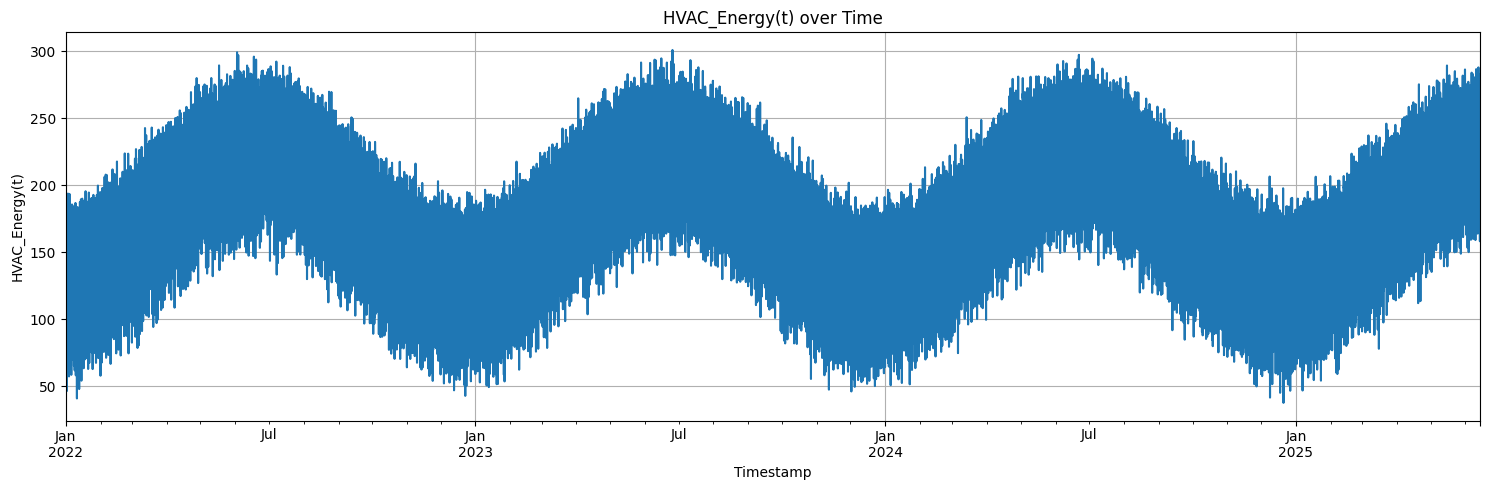

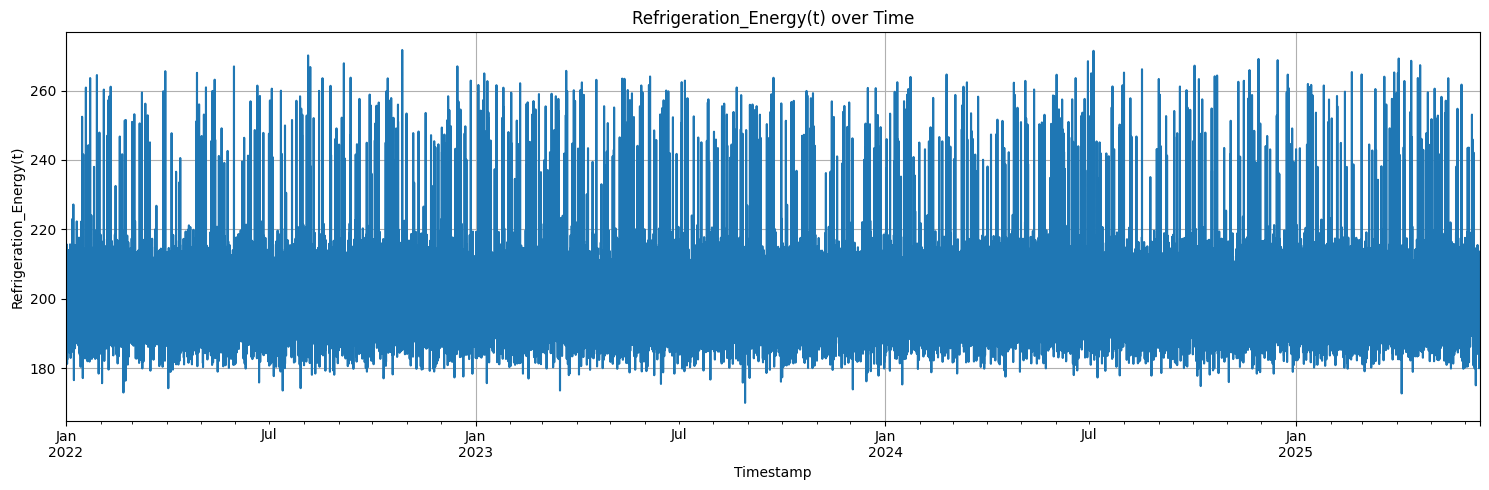

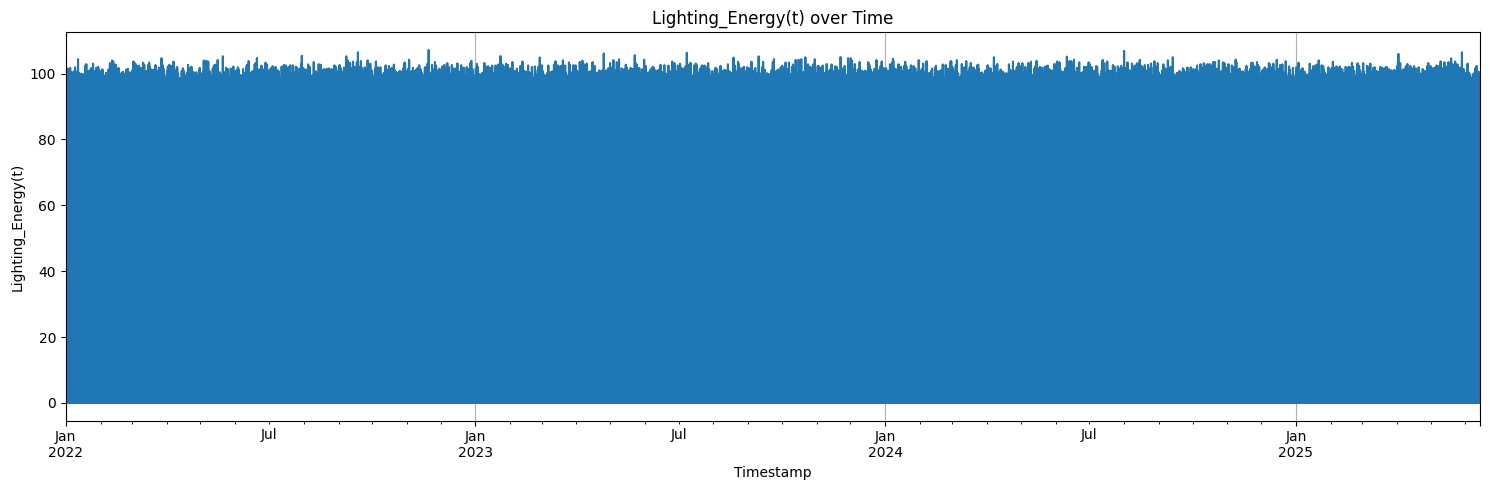

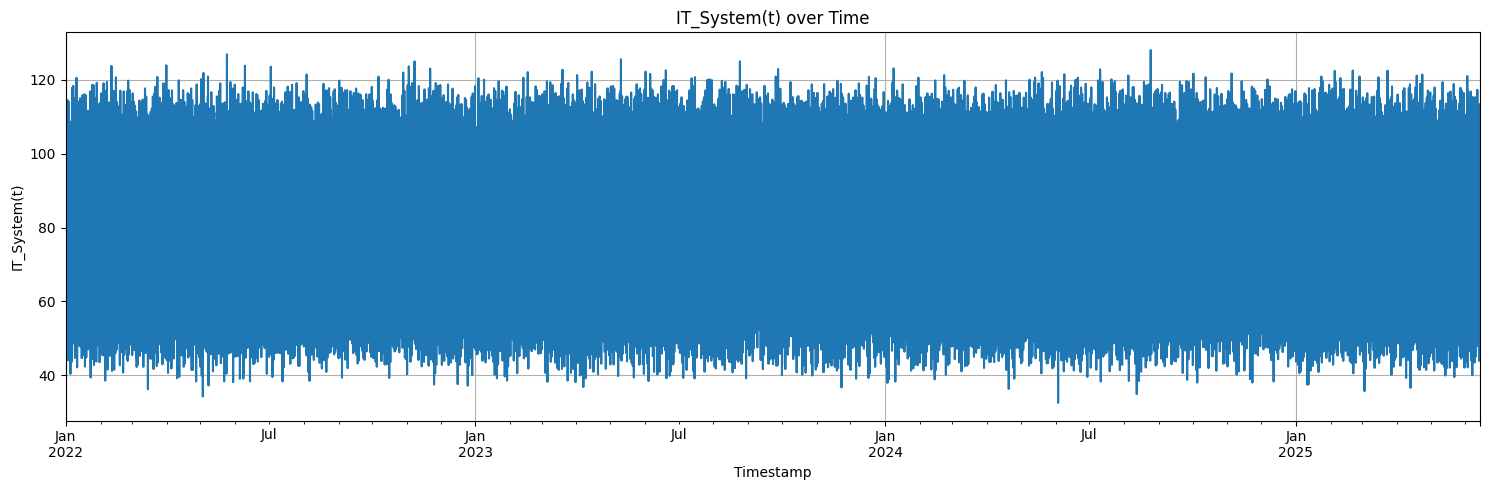

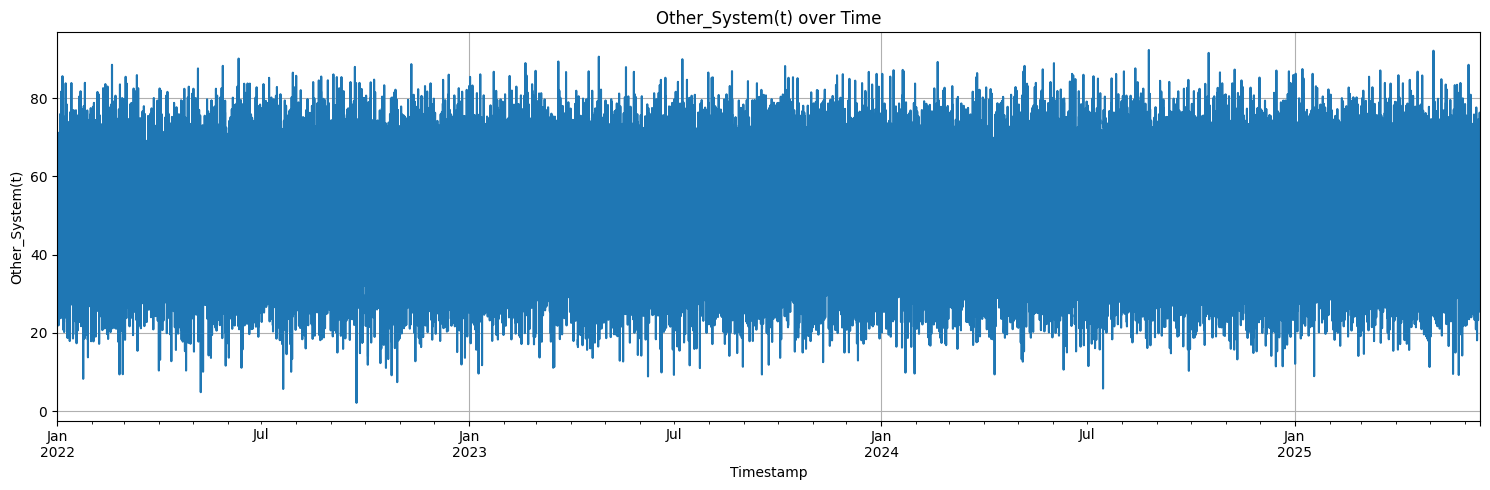

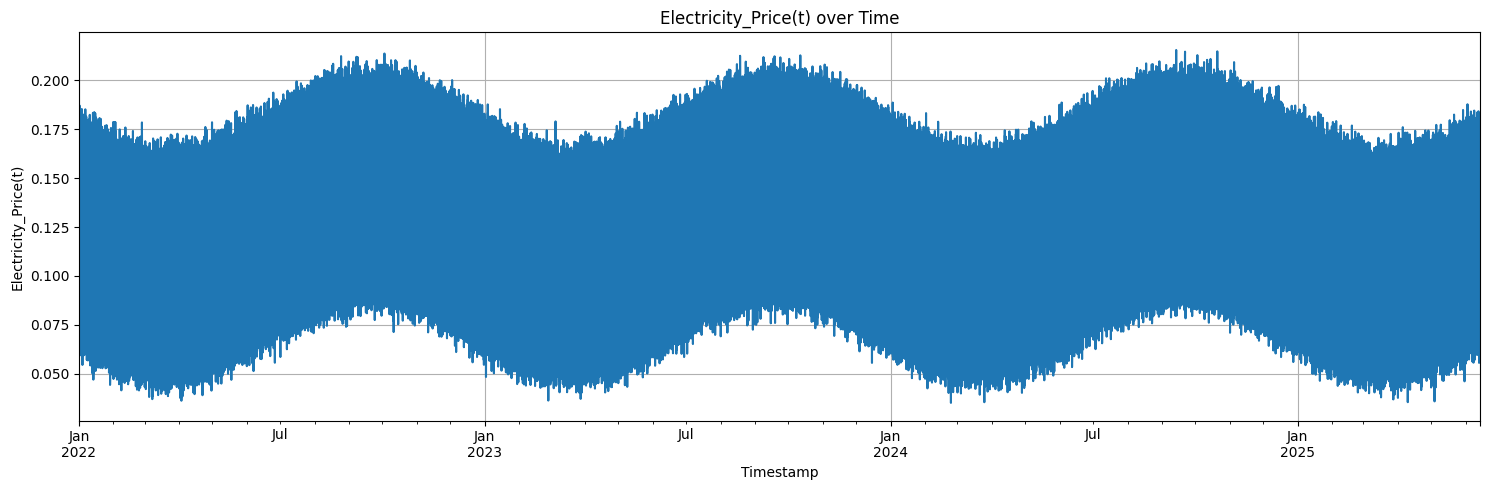

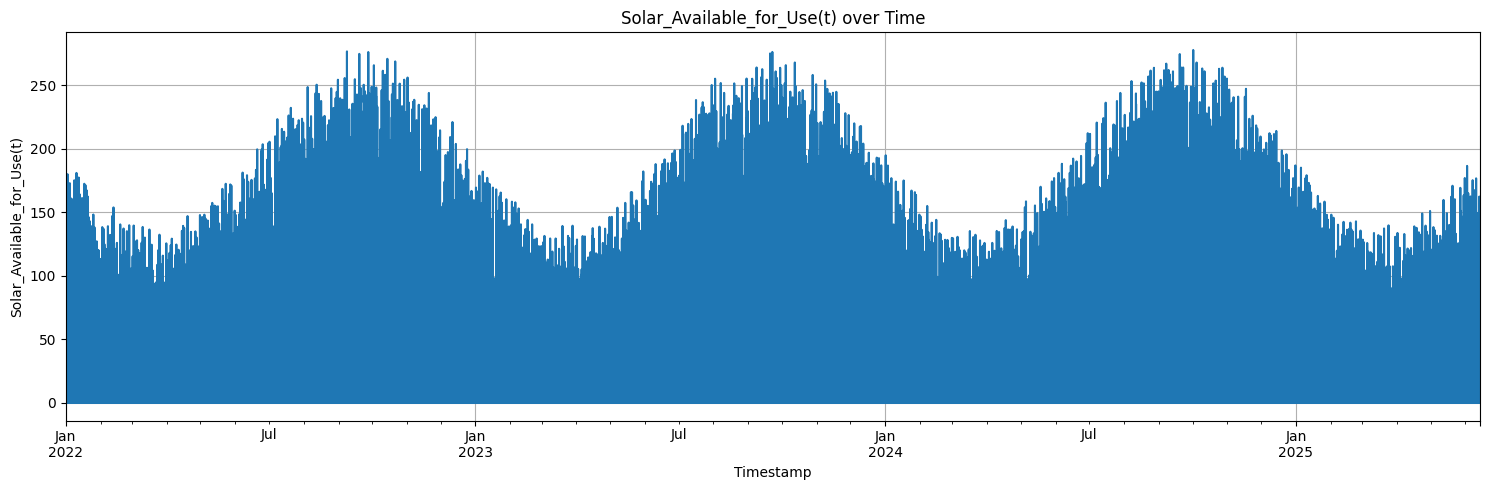

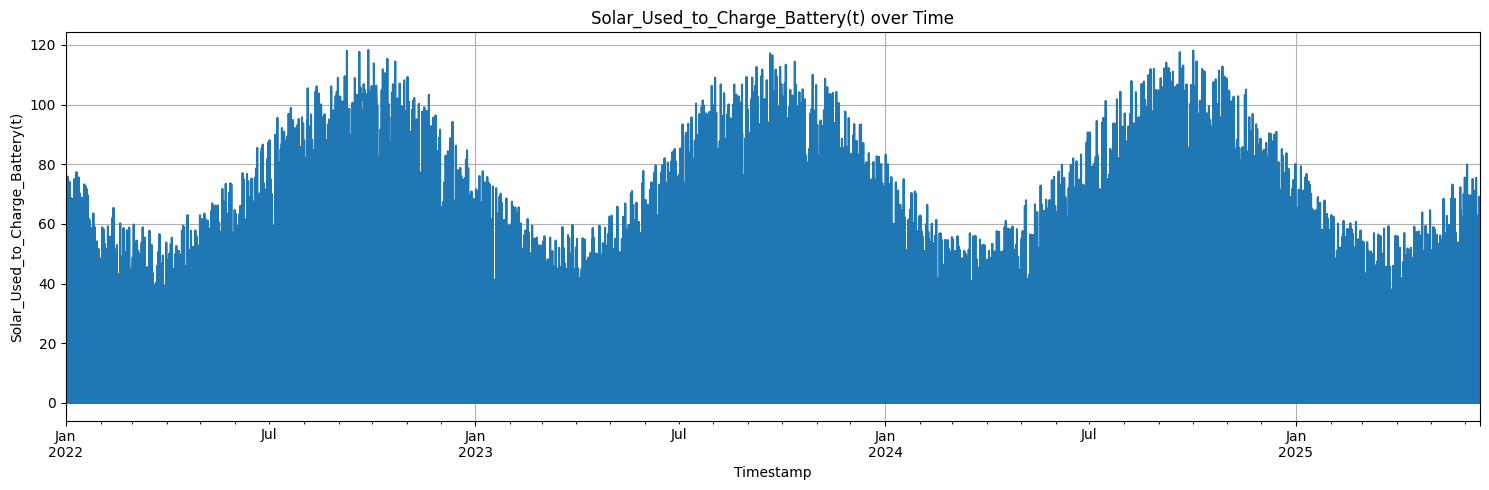

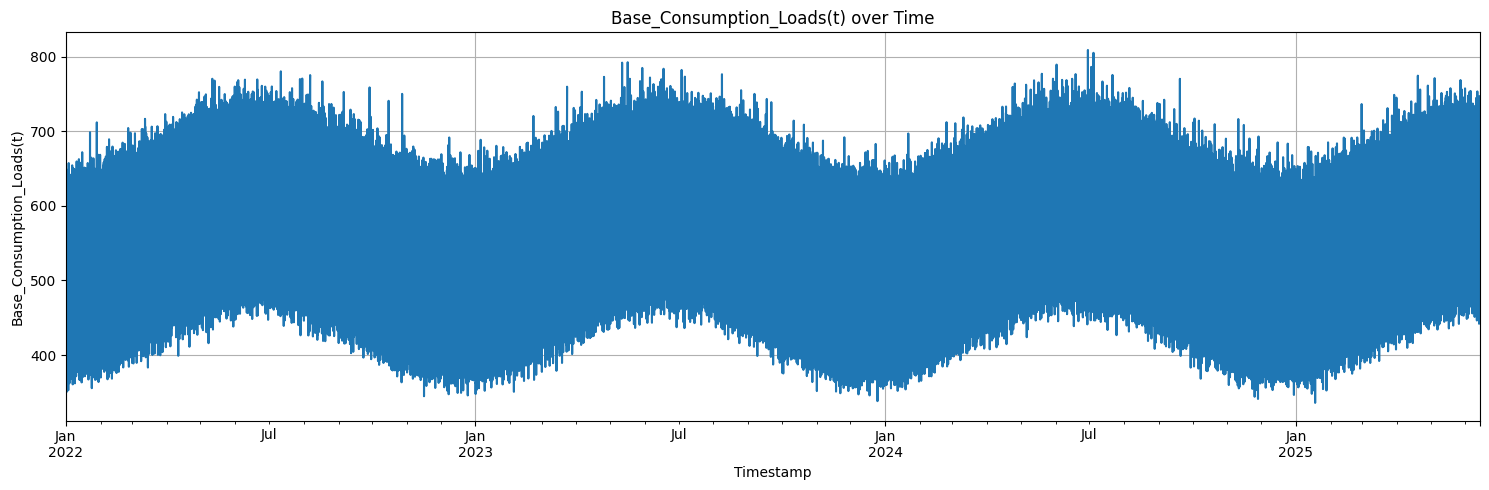

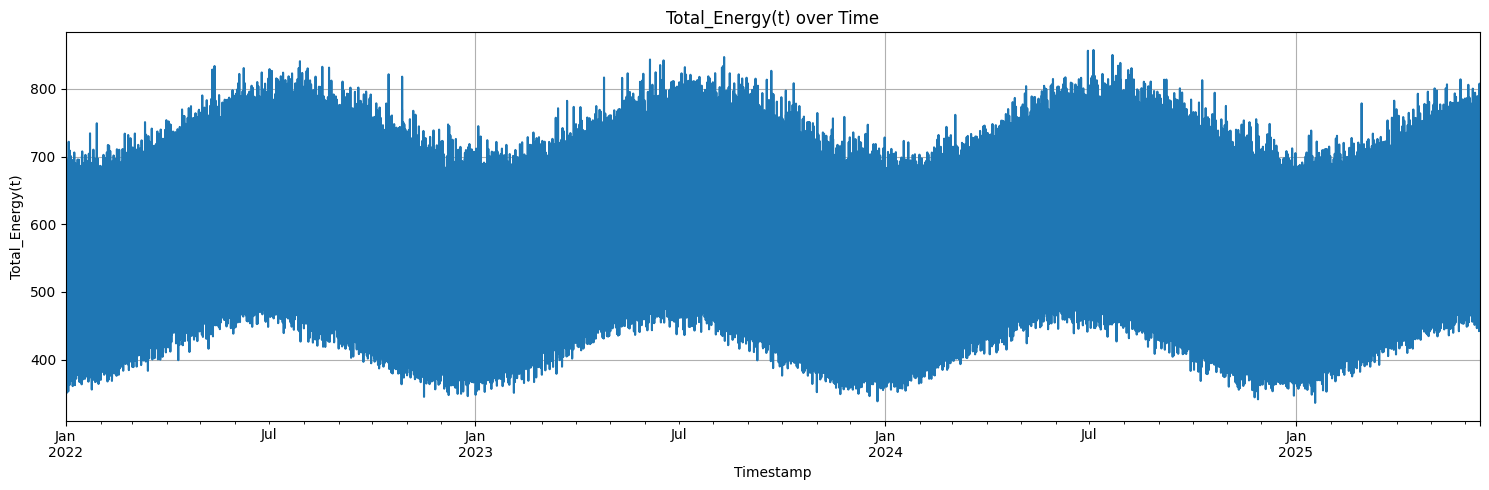

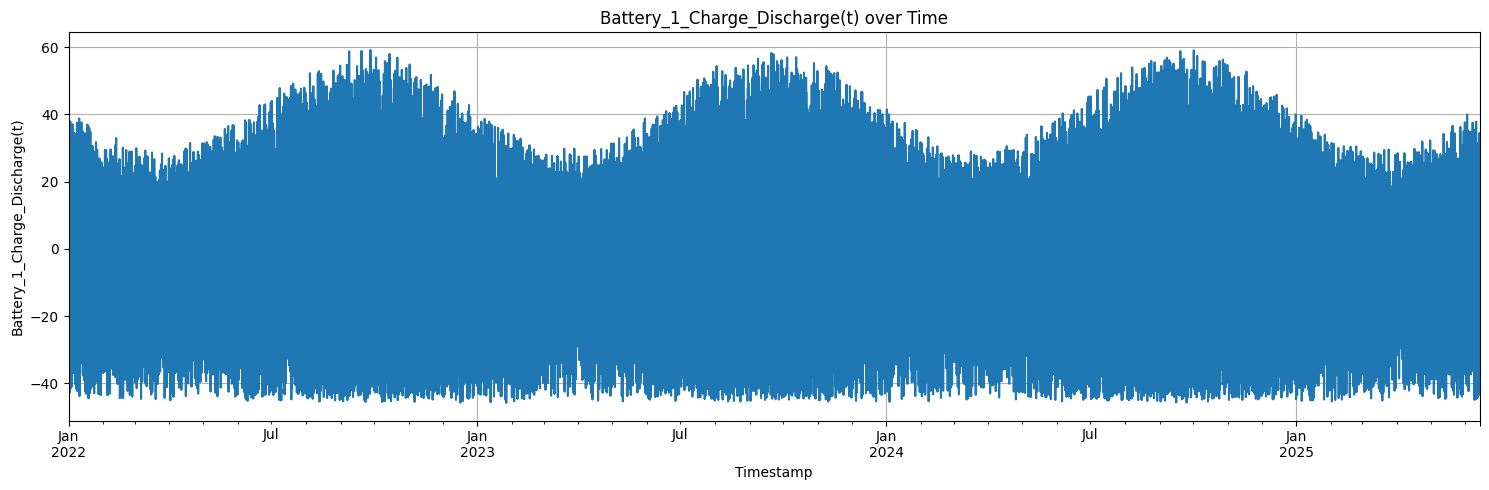

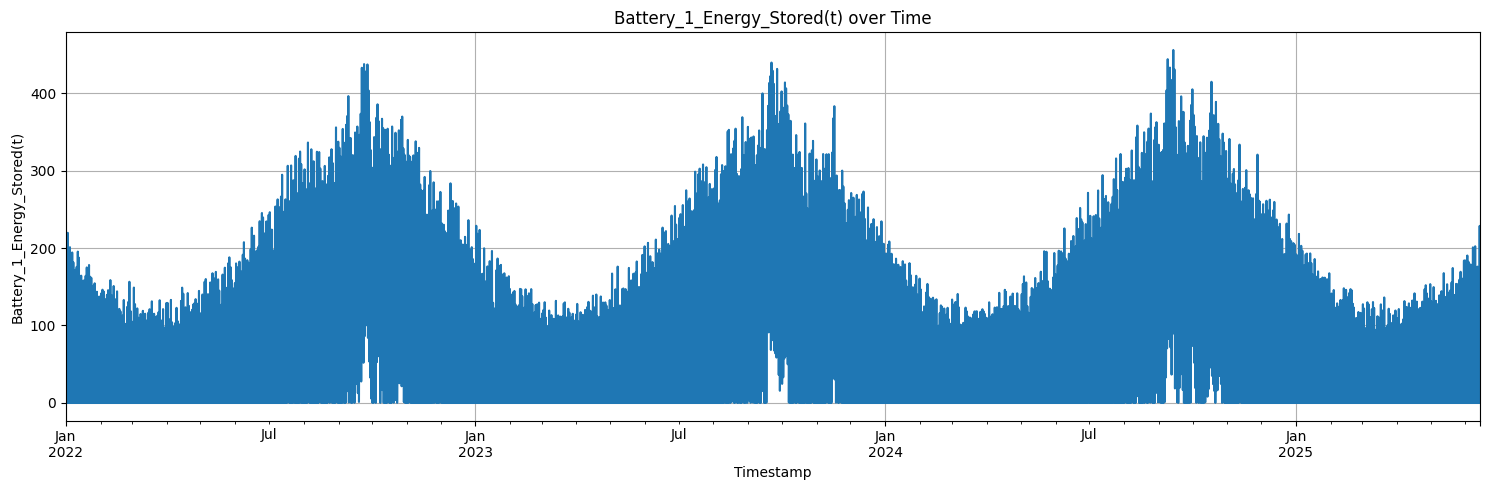

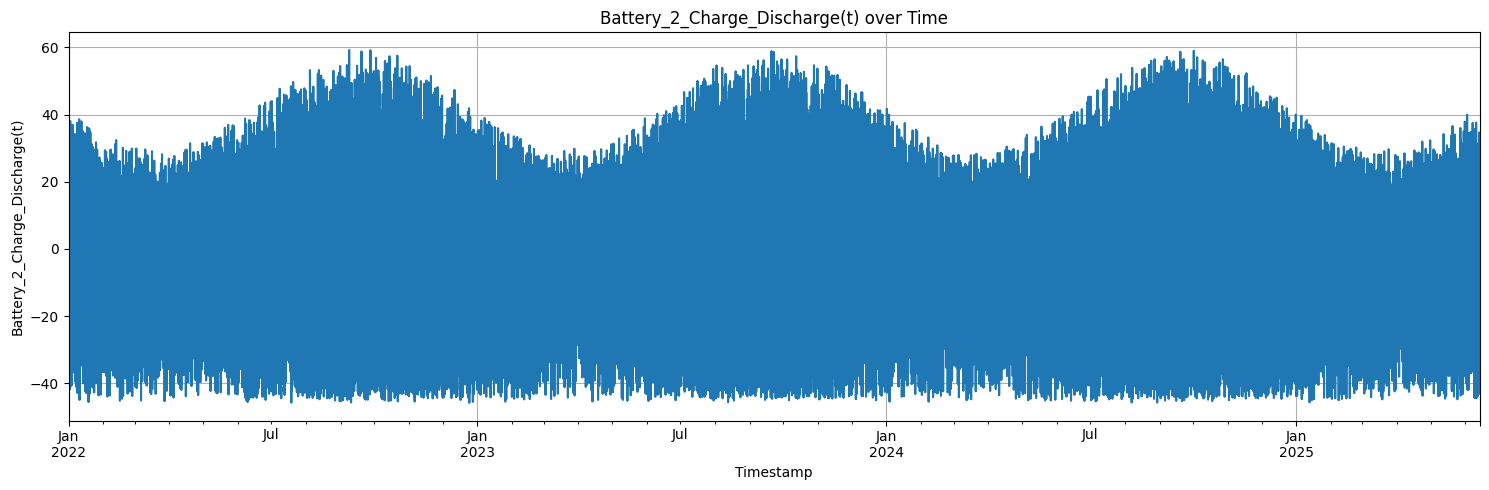

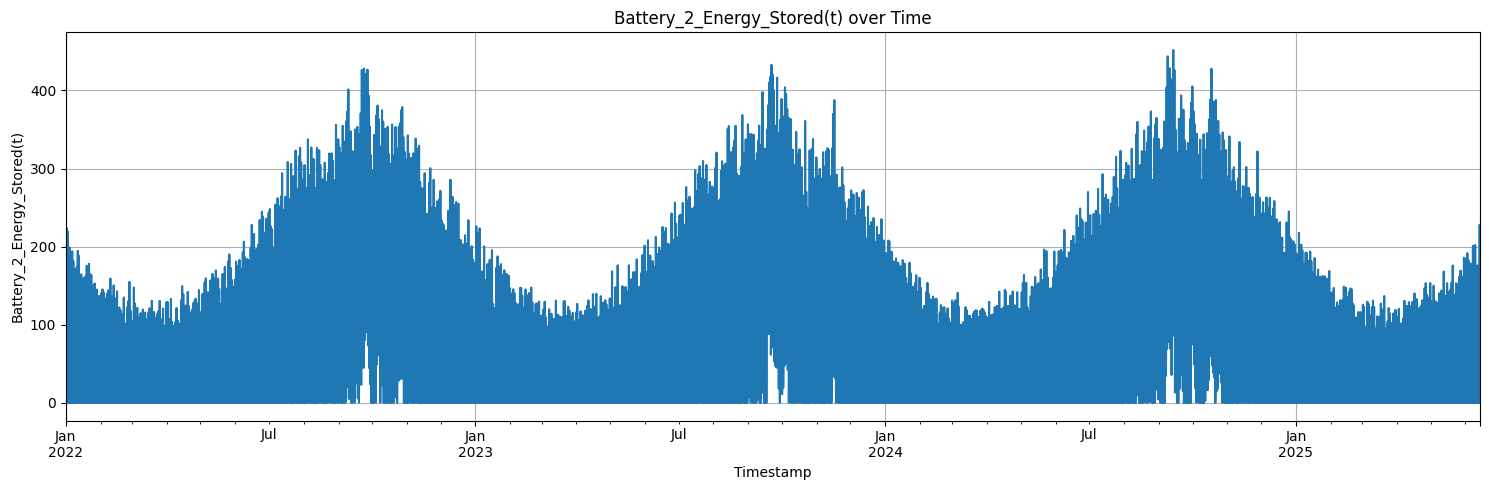

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 1. Load CSV file
file_path = 'complete_history_store1.csv'  # Change to your actual file path
df = pd.read_csv(file_path, parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)

# ✅ 2. Plot each column separately
for column in df.columns:
    plt.figure(figsize=(15, 5))
    df[column].plot()
    plt.title(f'{column} over Time')
    plt.xlabel('Timestamp')
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
